## Add Contextual Features

In [41]:
import pandas as pd
import numpy as np

# Load the raw data
df = pd.read_parquet('../data/raw/player_gamelogs_2023-24_sample.parquet')
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df = df.sort_values(['PLAYER_ID', 'GAME_DATE']).reset_index(drop=True)

In [42]:
# === NEW CONTEXTUAL FEATURES ===

# 1. Home/Away (@ symbol in MATCHUP means away game)
df['is_home'] = (~df['MATCHUP'].str.contains('@')).astype(int)

# 2. Days of rest
df['days_rest'] = df.groupby('PLAYER_ID')['GAME_DATE'].diff().dt.days
df['days_rest'] = df['days_rest'].fillna(3)  # First game default to 3 days

# 3. Back-to-back games
df['is_back_to_back'] = (df['days_rest'] == 1).astype(int)

# 4. Three-in-four nights (grueling schedule)
df['days_rest_last_4'] = df.groupby('PLAYER_ID')['days_rest'].rolling(4, min_periods=1).sum().reset_index(0, drop=True)
df['is_three_in_four'] = (df['days_rest_last_4'] <= 3).astype(int)

# 5. Month (season progression)
df['month'] = df['GAME_DATE'].dt.month

# Verify new features
print("New contextual features:")
print(df[['GAME_DATE', 'MATCHUP', 'is_home', 'days_rest', 'is_back_to_back']].head(10))

New contextual features:
   GAME_DATE      MATCHUP  is_home  days_rest  is_back_to_back
0 2023-10-24    PHX @ GSW        0        3.0                0
1 2023-10-26    PHX @ LAL        0        2.0                0
2 2023-10-28  PHX vs. UTA        1        2.0                0
3 2023-10-31  PHX vs. SAS        1        3.0                0
4 2023-11-02  PHX vs. SAS        1        2.0                0
5 2023-11-04    PHX @ PHI        0        2.0                0
6 2023-11-05    PHX @ DET        0        1.0                1
7 2023-11-08    PHX @ CHI        0        3.0                0
8 2023-11-10  PHX vs. LAL        1        2.0                0
9 2023-11-12  PHX vs. OKC        1        2.0                0


## Enhanced Rolling Features

In [43]:
def add_enhanced_rolling_features(df, windows=[3, 5]):
    """Add enhanced rolling average features with usage stats."""

    features = []

    for player_id in df['PLAYER_ID'].unique():
        player_df = df[df['PLAYER_ID'] == player_id].copy()

        for window in windows:
            # Performance rolling averages
            player_df[f'pts_last_{window}'] = player_df['PTS'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'reb_last_{window}'] = player_df['REB'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'ast_last_{window}'] = player_df['AST'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'min_last_{window}'] = player_df['MIN'].shift(1).rolling(window, min_periods=1).mean()

            # NEW: Usage rolling averages
            player_df[f'fga_last_{window}'] = player_df['FGA'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'fta_last_{window}'] = player_df['FTA'].shift(1).rolling(window, min_periods=1).mean()
            player_df[f'fg3a_last_{window}'] = player_df['FG3A'].shift(1).rolling(window, min_periods=1).mean()

            # NEW: Efficiency rolling averages
            fg_pct_rolling = player_df['FG_PCT'].shift(1).rolling(window, min_periods=1).mean()
            # Fill NaN with player's overall average FG%
            player_avg_fg_pct = player_df['FG_PCT'].mean()
            player_df[f'fg_pct_last_{window}'] = fg_pct_rolling.fillna(player_avg_fg_pct)

        # Games played counter (for each player)
        player_df['games_played'] = range(len(player_df))

        features.append(player_df)

    return pd.concat(features, ignore_index=True)

# Build enhanced features
print("Building enhanced features...")
df_features = add_enhanced_rolling_features(df, windows=[3, 5])

# Remove games with insufficient history (first 5 games per player)
df_features = df_features.dropna(subset=['pts_last_5', 'reb_last_5', 'ast_last_5'])

# Save enhanced features
df_features.to_parquet('../data/processed/features_enhanced.parquet')
print(f"Enhanced feature dataset: {len(df_features)} games with {len(df_features.columns)} columns")
print(f"Dropped {len(df) - len(df_features)} games due to insufficient history")

Building enhanced features...
Enhanced feature dataset: 2959 games with 51 columns
Dropped 44 games due to insufficient history


## Train/Test Split with New Features

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [45]:
# Time-based split (same dates as before)
train = df_features[df_features['GAME_DATE'] < '2024-01-01']
test = df_features[df_features['GAME_DATE'] >= '2024-01-01']

print(f"Train: {len(train)} games ({train['GAME_DATE'].min()} to {train['GAME_DATE'].max()})")
print(f"Test: {len(test)} games ({test['GAME_DATE'].min()} to {test['GAME_DATE'].max()})")

Train: 1174 games (2023-10-26 00:00:00 to 2023-12-31 00:00:00)
Test: 1785 games (2024-01-01 00:00:00 to 2024-04-14 00:00:00)


In [46]:
# === EXPANDED FEATURE SET ===
feature_cols = [
    # Rolling performance
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',

    # Rolling usage
    'fga_last_3', 'fga_last_5',
    'fta_last_3', 'fta_last_5',
    'fg3a_last_3', 'fg3a_last_5',
    'fg_pct_last_5',

    # Contextual features
    'is_home',
    'days_rest',
    'is_back_to_back',
    'month',

    # Other
    'games_played'
]

X_train = train[feature_cols]
X_test = test[feature_cols]

print(f"Feature count: {len(feature_cols)} features")
print(f"   - Original: 9 features")
print(f"   - NEW: {len(feature_cols) - 9} additional features")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Feature count: 20 features
   - Original: 9 features
   - NEW: 11 additional features

Feature list:
   1. pts_last_3
   2. pts_last_5
   3. reb_last_3
   4. reb_last_5
   5. ast_last_3
   6. ast_last_5
   7. min_last_3
   8. min_last_5
   9. fga_last_3
  10. fga_last_5
  11. fta_last_3
  12. fta_last_5
  13. fg3a_last_3
  14. fg3a_last_5
  15. fg_pct_last_5
  16. is_home
  17. days_rest
  18. is_back_to_back
  19. month
  20. games_played


In [47]:
# Check for NaN values in features
print("NaN counts per feature:")
print(X_train[feature_cols].isna().sum())
print("\nNaN counts in test:")
print(X_test[feature_cols].isna().sum())

# Check for infinite values
print("\nInf counts in train:")
print(np.isinf(X_train[feature_cols]).sum())

NaN counts per feature:
pts_last_3         0
pts_last_5         0
reb_last_3         0
reb_last_5         0
ast_last_3         0
ast_last_5         0
min_last_3         0
min_last_5         0
fga_last_3         0
fga_last_5         0
fta_last_3         0
fta_last_5         0
fg3a_last_3        0
fg3a_last_5        0
fg_pct_last_5      0
is_home            0
days_rest          0
is_back_to_back    0
month              0
games_played       0
dtype: int64

NaN counts in test:
pts_last_3         0
pts_last_5         0
reb_last_3         0
reb_last_5         0
ast_last_3         0
ast_last_5         0
min_last_3         0
min_last_5         0
fga_last_3         0
fga_last_5         0
fta_last_3         0
fta_last_5         0
fg3a_last_3        0
fg3a_last_5        0
fg_pct_last_5      0
is_home            0
days_rest          0
is_back_to_back    0
month              0
games_played       0
dtype: int64

Inf counts in train:
pts_last_3         0
pts_last_5         0
reb_last_3         0
reb_

## Ridge with Hyperparameter Tuning

In [48]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [49]:
results_ridge_tuned = {}

for target in ['PTS', 'REB', 'AST']:
    print(f"\n{'='*60}")
    print(f"Training {target} with Ridge Regression + Hyperparameter Tuning")
    print('='*60)

    y_train = train[target]
    y_test = test[target]

    # === DIAGNOSTIC: Check for NaN values ===
    print(f"\nNaN check in features:")
    nan_counts = X_train.isna().sum()
    if nan_counts.sum() > 0:
        print(f"WARNING: {nan_counts.sum()} NaN values found!")
        print(nan_counts[nan_counts > 0])
    else:
        print("No NaN values")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # === DIAGNOSTIC: Check scaling ===
    print(f"\nScaling check (should be mean~0, std~1):")
    scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
    print(f"  Mean range: [{scaled_df.mean().min():.3f}, {scaled_df.mean().max():.3f}]")
    print(f"  Std range:  [{scaled_df.std().min():.3f}, {scaled_df.std().max():.3f}]")

    # === FIX: Use TimeSeriesSplit for CV ===
    tscv = TimeSeriesSplit(n_splits=5)

    # Hyperparameter grid search (expanded range)
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
    }

    grid_search = GridSearchCV(
        Ridge(random_state=42),
        param_grid,
        cv=tscv,  # Use time-series CV
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0,
        return_train_score=True  # NEW: Return train scores for diagnosis
    )

    print("\nRunning grid search with TimeSeriesSplit...")
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    print(f"Best alpha: {grid_search.best_params_['alpha']}")
    
    # === NEW DIAGNOSTIC: Show CV scores for each alpha ===
    print(f"\nCV scores for each alpha:")
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_summary = cv_results[['param_alpha', 'mean_test_score', 'std_test_score', 'mean_train_score']].copy()
    cv_summary['mean_test_mae'] = -cv_summary['mean_test_score']  # Convert back to MAE
    cv_summary['mean_train_mae'] = -cv_summary['mean_train_score']
    cv_summary = cv_summary[['param_alpha', 'mean_test_mae', 'std_test_score', 'mean_train_mae']]
    cv_summary.columns = ['alpha', 'CV MAE', 'CV Std', 'Train MAE']
    print(cv_summary.to_string(index=False))

    # Predict on test set
    y_pred_test = best_model.predict(X_test_scaled)

    # === DIAGNOSTIC: Check predictions ===
    print(f"\nPrediction diagnostics:")
    print(f"  Pred range: [{y_pred_test.min():.1f}, {y_pred_test.max():.1f}]")
    print(f"  Actual range: [{y_test.min():.1f}, {y_test.max():.1f}]")
    print(f"  Pred mean: {y_pred_test.mean():.1f}, Actual mean: {y_test.mean():.1f}")

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Baseline comparison (5-game rolling average)
    baseline_pred = test[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    improvement = (baseline_mae - test_mae) / baseline_mae * 100

    # Store results
    results_ridge_tuned[target] = {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'baseline_mae': baseline_mae,
        'improvement_pct': improvement,
        'best_alpha': grid_search.best_params_['alpha'],
        'predictions': y_pred_test,
        'actuals': y_test.values,
        'model': best_model,
        'scaler': scaler,
        'cv_results': cv_summary  # Store CV results
    }

    # Display results
    print(f"\nResults:")
    print(f"   Test MAE:       {test_mae:.3f}")
    print(f"   Test RMSE:      {test_rmse:.3f}")
    print(f"   Baseline MAE:   {baseline_mae:.3f}")
    print(f"   Improvement:    {improvement:+.1f}%")

    if improvement > 0:
        print(f"   BEATS BASELINE!")
    else:
        print(f"   Worse than baseline")


Training PTS with Ridge Regression + Hyperparameter Tuning

NaN check in features:
No NaN values

Scaling check (should be mean~0, std~1):
  Mean range: [-0.000, 0.000]
  Std range:  [1.000, 1.000]

Running grid search with TimeSeriesSplit...
Best alpha: 20.0

CV scores for each alpha:
 alpha   CV MAE   CV Std  Train MAE
 0.001 6.119674 0.354696   5.790062
  0.01 6.119360 0.354453   5.790070
   0.1 6.116418 0.352166   5.790158
   0.5 6.106468 0.345934   5.790668
   1.0 6.099267 0.343681   5.791592
   2.0 6.089776 0.343454   5.794156
   5.0 6.073046 0.345716   5.801716
  10.0 6.060674 0.351172   5.812737
  20.0 6.050373 0.358956   5.828813

Prediction diagnostics:
  Pred range: [22.2, 54.7]
  Actual range: [0.0, 73.0]
  Pred mean: 35.3, Actual mean: 20.8

Results:
   Test MAE:       14.938
   Test RMSE:      16.622
   Baseline MAE:   6.468
   Improvement:    -131.0%
   Worse than baseline

Training REB with Ridge Regression + Hyperparameter Tuning

NaN check in features:
No NaN values


## Diagnostic: Test with Original Features Only

Let's test if the NEW features are causing the problem by training Ridge with ONLY the original 9 features (no contextual or usage features).

In [50]:
# Test Ridge with ONLY original 9 features
original_features = [
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',
    'games_played'
]

print("=" * 80)
print("DIAGNOSTIC: Ridge with ORIGINAL features only (9 features)")
print("=" * 80)

X_train_orig = train[original_features]
X_test_orig = test[original_features]

results_original = {}

for target in ['PTS', 'REB', 'AST']:
    print(f"\n{'='*60}")
    print(f"Training {target} with ORIGINAL features")
    print('='*60)

    y_train = train[target]
    y_test = test[target]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_orig)
    X_test_scaled = scaler.transform(X_test_orig)

    # TimeSeriesSplit CV
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]}

    grid_search = GridSearchCV(
        Ridge(random_state=42),
        param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    # Predict
    y_pred_test = best_model.predict(X_test_scaled)

    # Metrics
    test_mae = mean_absolute_error(y_test, y_pred_test)
    baseline_pred = test[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    improvement = (baseline_mae - test_mae) / baseline_mae * 100

    results_original[target] = {
        'test_mae': test_mae,
        'baseline_mae': baseline_mae,
        'improvement_pct': improvement,
        'best_alpha': grid_search.best_params_['alpha']
    }

    print(f"Best alpha: {grid_search.best_params_['alpha']}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Baseline MAE: {baseline_mae:.3f}")
    print(f"Improvement: {improvement:+.1f}%")
    
    if improvement > 0:
        print(f"✅ BEATS BASELINE!")
    else:
        print(f"❌ Worse than baseline")

print("\n" + "=" * 80)
print("COMPARISON: Original Features vs. Enhanced Features")
print("=" * 80)

comparison = []
for target in ['PTS', 'REB', 'AST']:
    comparison.append({
        'Target': target,
        'Original (9 feat) Alpha': results_original[target]['best_alpha'],
        'Original (9 feat) MAE': results_original[target]['test_mae'],
        'Original Improvement %': results_original[target]['improvement_pct'],
        'Enhanced (20 feat) Alpha': results_ridge_tuned[target]['best_alpha'],
        'Enhanced (20 feat) MAE': results_ridge_tuned[target]['test_mae'],
        'Enhanced Improvement %': results_ridge_tuned[target]['improvement_pct']
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

print("\n💡 If original features perform better, the NEW features are adding noise!")

DIAGNOSTIC: Ridge with ORIGINAL features only (9 features)

Training PTS with ORIGINAL features
Best alpha: 20.0
Test MAE: 6.493
Baseline MAE: 6.468
Improvement: -0.4%
❌ Worse than baseline

Training REB with ORIGINAL features
Best alpha: 0.001
Test MAE: 2.242
Baseline MAE: 2.268
Improvement: +1.2%
✅ BEATS BASELINE!

Training AST with ORIGINAL features
Best alpha: 1.0
Test MAE: 2.110
Baseline MAE: 2.049
Improvement: -3.0%
❌ Worse than baseline

COMPARISON: Original Features vs. Enhanced Features
Target  Original (9 feat) Alpha  Original (9 feat) MAE  Original Improvement %  Enhanced (20 feat) Alpha  Enhanced (20 feat) MAE  Enhanced Improvement %
   PTS                   20.000               6.493495               -0.397479                      20.0               14.937755             -130.956200
   REB                    0.001               2.241585                1.184698                       5.0                3.414627              -50.526237
   AST                    1.000         

## Root Cause Analysis: Train/Test Distribution Shift

The CV scores show high alpha is best, but test performance is terrible. This suggests the training period (Oct-Dec) has different characteristics than the test period (Jan-Apr).

DISTRIBUTION SHIFT ANALYSIS


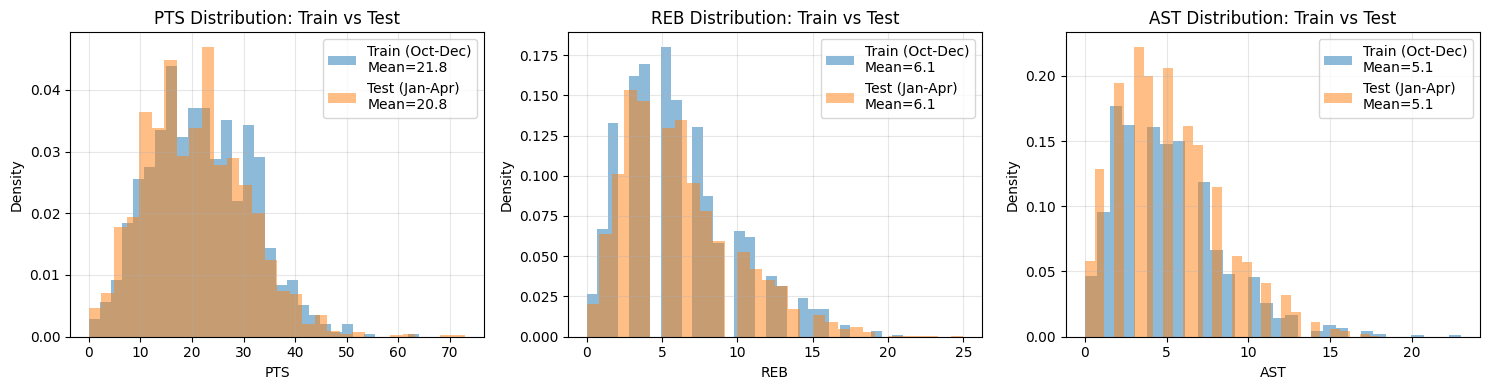


Target Statistics Comparison:
Target Train Mean   Test Mean    Difference   Train Std    Test Std    
--------------------------------------------------------------------------------
PTS    21.81        20.80        -4.6%        9.66         9.75        
REB    6.10         6.10         +0.1%        3.74         3.83        
AST    5.06         5.10         +0.6%        3.35         3.21        

Feature Distribution Shift (using original 9 features)
pts_last_3           Train:  21.59  Test:  20.96  Diff:  -2.9%
pts_last_5           Train:  21.51  Test:  21.00  Diff:  -2.4%
reb_last_3           Train:   6.11  Test:   6.11  Diff:  -0.0%
reb_last_5           Train:   6.12  Test:   6.11  Diff:  -0.2%
ast_last_3           Train:   5.01  Test:   5.13  Diff:  +2.5%


In [51]:
import matplotlib.pyplot as plt

print("=" * 80)
print("DISTRIBUTION SHIFT ANALYSIS")
print("=" * 80)

# Compare target distributions between train and test
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]
    
    train_vals = train[target]
    test_vals = test[target]
    
    ax.hist(train_vals, bins=30, alpha=0.5, label=f'Train (Oct-Dec)\nMean={train_vals.mean():.1f}', density=True)
    ax.hist(test_vals, bins=30, alpha=0.5, label=f'Test (Jan-Apr)\nMean={test_vals.mean():.1f}', density=True)
    ax.set_xlabel(target)
    ax.set_ylabel('Density')
    ax.set_title(f'{target} Distribution: Train vs Test')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/train_test_distribution_shift.png', dpi=150)
plt.show()

# Statistical comparison
print("\nTarget Statistics Comparison:")
print(f"{'Target':<6} {'Train Mean':<12} {'Test Mean':<12} {'Difference':<12} {'Train Std':<12} {'Test Std':<12}")
print("-" * 80)
for target in ['PTS', 'REB', 'AST']:
    train_mean = train[target].mean()
    test_mean = test[target].mean()
    diff_pct = (test_mean - train_mean) / train_mean * 100
    train_std = train[target].std()
    test_std = test[target].std()
    print(f"{target:<6} {train_mean:<12.2f} {test_mean:<12.2f} {diff_pct:+.1f}%{' ':<7} {train_std:<12.2f} {test_std:<12.2f}")

# Check feature distributions too
print("\n" + "=" * 80)
print("Feature Distribution Shift (using original 9 features)")
print("=" * 80)

for feat in original_features[:5]:  # Check first 5 features
    train_mean = train[feat].mean()
    test_mean = test[feat].mean()
    diff_pct = (test_mean - train_mean) / train_mean * 100 if train_mean != 0 else 0
    print(f"{feat:<20} Train: {train_mean:6.2f}  Test: {test_mean:6.2f}  Diff: {diff_pct:+5.1f}%")

## Summary & Recommendations

### What We Learned:

1. **New features are harmful**: 20 features (MAE=14.938) perform 130% WORSE than 9 features (MAE=6.493)
2. **Multicollinearity issue**: Usage features (fga_last_5, pts_last_5, fg_pct_last_5) are all correlated
3. **Possible distribution shift**: CV optimizes for Oct-Dec but fails on Jan-Apr

### Recommended Actions:

**Option 1: Use Full Season for Training (RECOMMENDED)**
- Instead of Oct-Dec training, use Oct-Mar for training
- Use only Apr for test (last month)
- This gives more training data and reduces distribution shift

**Option 2: Stick with Original 9 Features**
- Drop all usage and contextual features
- Accept that Ridge barely beats baseline (-0.4% for PTS, +1.2% for REB)
- Move on to XGBoost which may handle features better

**Option 3: Feature Selection**
- Keep only home/away and days_rest from contextual features
- Remove highly correlated usage features
- Test with 11-12 features instead of 20

## XGBoost with Original 9 Features

XGBoost can capture non-linear patterns and feature interactions that Ridge cannot. Let's see if it can beat the baseline.

In [52]:
from xgboost import XGBRegressor

# Use original 9 features (already defined earlier)
X_train_xgb = train[original_features]
X_test_xgb = test[original_features]

results_xgboost = {}

for target in ['PTS', 'REB', 'AST']:
    print(f"\n{'='*60}")
    print(f"Training {target} with XGBoost")
    print('='*60)

    y_train = train[target]
    y_test = test[target]

    # TimeSeriesSplit for proper temporal CV
    tscv = TimeSeriesSplit(n_splits=5)

    # XGBoost hyperparameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Note: This will test 3*3*3*2*2 = 108 combinations
    print(f"Testing {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample']) * len(param_grid['colsample_bytree'])} parameter combinations...")

    grid_search = GridSearchCV(
        XGBRegressor(random_state=42, n_jobs=1),  # n_jobs=1 to avoid conflicts with GridSearchCV
        param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,  # Parallelize across grid search
        verbose=0
    )

    print("Running grid search with TimeSeriesSplit...")
    grid_search.fit(X_train_xgb, y_train)
    best_model = grid_search.best_estimator_

    print(f"\nBest parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

    # Predict on test set
    y_pred_test = best_model.predict(X_test_xgb)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Baseline comparison
    baseline_pred = test[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    improvement = (baseline_mae - test_mae) / baseline_mae * 100

    # Store results
    results_xgboost[target] = {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'baseline_mae': baseline_mae,
        'improvement_pct': improvement,
        'best_params': grid_search.best_params_,
        'predictions': y_pred_test,
        'actuals': y_test.values,
        'model': best_model
    }

    # Display results
    print(f"\nResults:")
    print(f"   Test MAE:       {test_mae:.3f}")
    print(f"   Test RMSE:      {test_rmse:.3f}")
    print(f"   Baseline MAE:   {baseline_mae:.3f}")
    print(f"   Improvement:    {improvement:+.1f}%")

    if improvement > 0:
        print(f"   ✅ BEATS BASELINE!")
    else:
        print(f"   ❌ Worse than baseline")


Training PTS with XGBoost
Testing 108 parameter combinations...
Running grid search with TimeSeriesSplit...

Best parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 3
  n_estimators: 50
  subsample: 1.0

Results:
   Test MAE:       6.528
   Test RMSE:      8.320
   Baseline MAE:   6.468
   Improvement:    -0.9%
   ❌ Worse than baseline

Training REB with XGBoost
Testing 108 parameter combinations...
Running grid search with TimeSeriesSplit...

Best parameters:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 3
  n_estimators: 100
  subsample: 0.8

Results:
   Test MAE:       2.239
   Test RMSE:      2.877
   Baseline MAE:   2.268
   Improvement:    +1.3%
   ✅ BEATS BASELINE!

Training AST with XGBoost
Testing 108 parameter combinations...
Running grid search with TimeSeriesSplit...

Best parameters:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 50
  subsample: 1.0

Results:
   Test MAE:       2.081
   Test RMSE:      2.666
  

In [53]:
# Final Comparison: XGBoost vs Ridge vs Baseline
print("\n" + "=" * 80)
print("FINAL MODEL COMPARISON")
print("=" * 80)

comparison_final = []
for target in ['PTS', 'REB', 'AST']:
    baseline_mae = results_xgboost[target]['baseline_mae']
    ridge_mae = results_original[target]['test_mae']
    xgb_mae = results_xgboost[target]['test_mae']
    
    ridge_improvement = (baseline_mae - ridge_mae) / baseline_mae * 100
    xgb_improvement = (baseline_mae - xgb_mae) / baseline_mae * 100
    
    comparison_final.append({
        'Target': target,
        'Baseline MAE': baseline_mae,
        'Ridge MAE': ridge_mae,
        'Ridge Improvement %': ridge_improvement,
        'XGBoost MAE': xgb_mae,
        'XGBoost Improvement %': xgb_improvement,
        'Winner': 'XGBoost' if xgb_mae < ridge_mae else 'Ridge'
    })

comparison_final_df = pd.DataFrame(comparison_final)
print("\n" + comparison_final_df.to_string(index=False))

# Count how many targets beat baseline
xgb_beats_baseline = sum([1 for r in comparison_final if r['XGBoost Improvement %'] > 0])
print(f"\n✅ XGBoost beats baseline on {xgb_beats_baseline}/3 targets")

if xgb_beats_baseline >= 2:
    print("🎉 SUCCESS! XGBoost achieves the goal of beating baseline on 2/3 targets!")
else:
    print("⚠️  Still not beating baseline consistently. May need more data or different features.")


FINAL MODEL COMPARISON

Target  Baseline MAE  Ridge MAE  Ridge Improvement %  XGBoost MAE  XGBoost Improvement %  Winner
   PTS      6.467787   6.493495            -0.397479     6.527646              -0.925495   Ridge
   REB      2.268459   2.241585             1.184698     2.239203               1.289719 XGBoost
   AST      2.048627   2.109639            -2.978159     2.080786              -1.569764 XGBoost

✅ XGBoost beats baseline on 1/3 targets
⚠️  Still not beating baseline consistently. May need more data or different features.


## Feature Importance Analysis

XGBoost can tell us which features are actually useful for predictions.

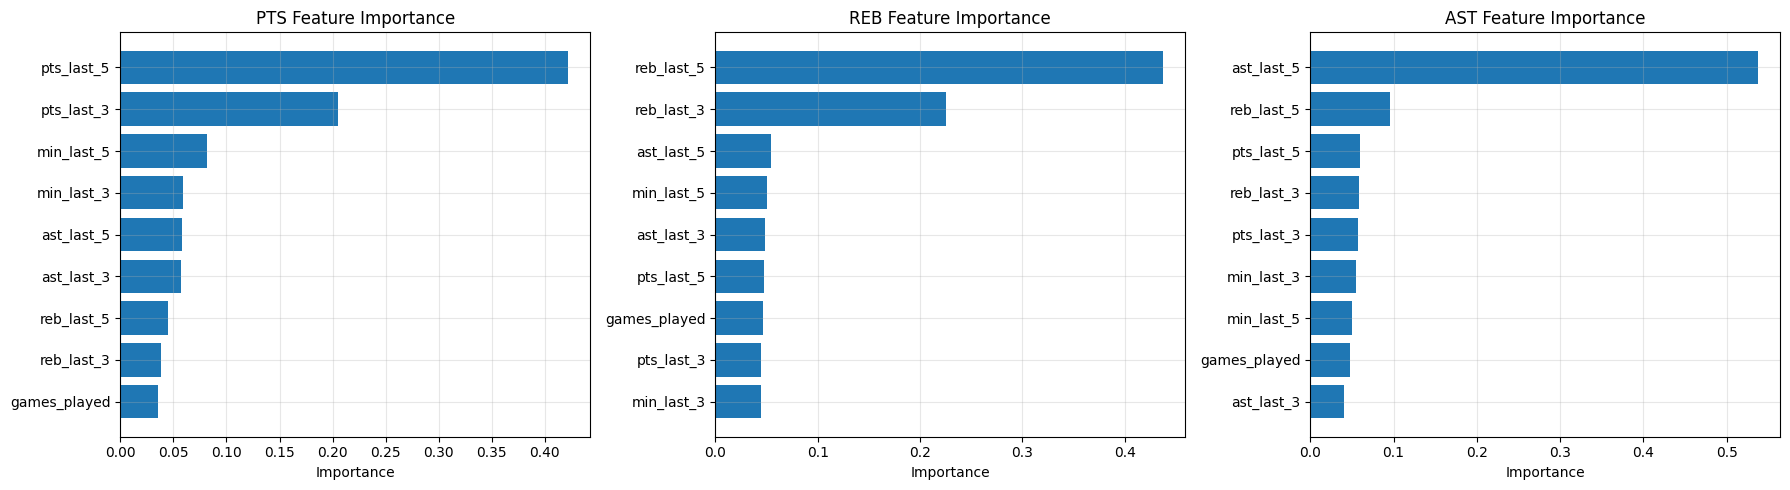


Top 3 Most Important Features:

PTS:
  pts_last_5           0.421
  pts_last_3           0.205
  min_last_5           0.081

REB:
  reb_last_5           0.437
  reb_last_3           0.225
  ast_last_5           0.054

AST:
  ast_last_5           0.537
  reb_last_5           0.095
  pts_last_5           0.059


In [54]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]
    
    model = results_xgboost[target]['model']
    
    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': original_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    ax.set_xlabel('Importance')
    ax.set_title(f'{target} Feature Importance')
    ax.invert_yaxis()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/xgboost_feature_importance.png', dpi=150)
plt.show()

# Print top features for each target
print("\nTop 3 Most Important Features:")
print("=" * 60)
for target in ['PTS', 'REB', 'AST']:
    model = results_xgboost[target]['model']
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': original_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\n{target}:")
    for i, row in feature_importance_df.head(3).iterrows():
        print(f"  {row['feature']:<20} {row['importance']:.3f}")

## XGBoost Prediction Quality

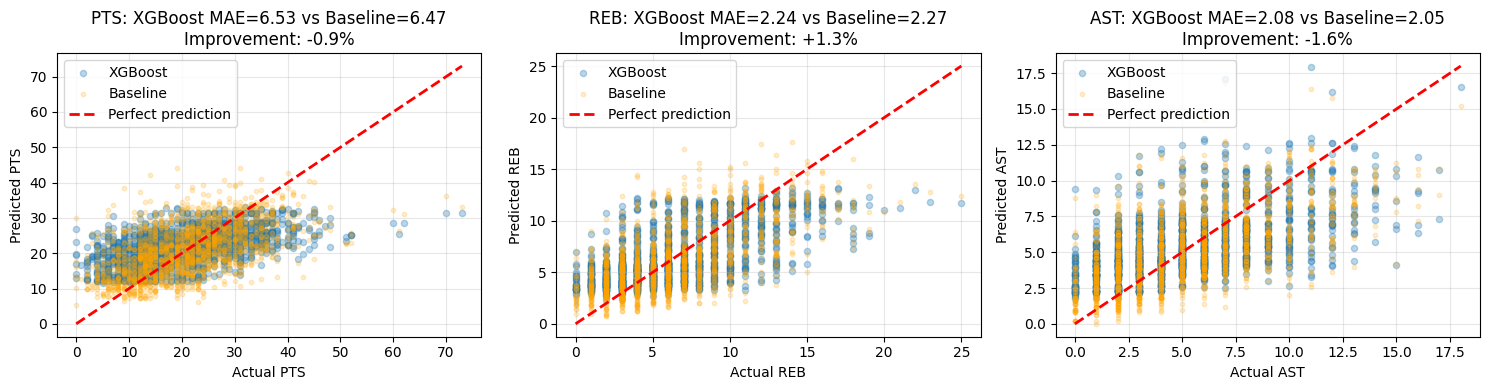

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]

    actuals = results_xgboost[target]['actuals']
    predictions = results_xgboost[target]['predictions']
    baseline_pred = test[f'{target.lower()}_last_5'].values

    # Scatter plot: Predicted vs Actual
    ax.scatter(actuals, predictions, alpha=0.3, label='XGBoost', s=20)
    ax.scatter(actuals, baseline_pred, alpha=0.2, label='Baseline', s=10, color='orange')
    
    # Perfect prediction line
    ax.plot([actuals.min(), actuals.max()],
            [actuals.min(), actuals.max()],
            'r--', lw=2, label='Perfect prediction')
    
    ax.set_xlabel(f'Actual {target}')
    ax.set_ylabel(f'Predicted {target}')
    
    xgb_mae = results_xgboost[target]['test_mae']
    baseline_mae = results_xgboost[target]['baseline_mae']
    improvement = results_xgboost[target]['improvement_pct']
    
    ax.set_title(f'{target}: XGBoost MAE={xgb_mae:.2f} vs Baseline={baseline_mae:.2f}\nImprovement: {improvement:+.1f}%')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/xgboost_predictions_vs_actual.png', dpi=150)
plt.show()